# **End-to-End Multi-Class Dog Breed Classification**

This notebook builds an end-to-end multi-class image classifier using Tensorflow and Tensorflow Hub.

## 1. Problem
Identify the breed of a dog given an image of a dog.

## 2. Data
The data os from Kaggle's dog breed identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features
> Some information about the data:
* Unstructured data
* 120 dog breeds
* 10,000 + images in `training` and `validation` set


## 5. Getting the Workspace Ready

In [1]:
# Importing Libraries

## Imnporting TensorFlow
import tensorflow as tf
print("TF version", tf.__version__)

## Import Tensorflow Hub
import tensorflow_hub as hub
print("TF Hub version", hub.__version__)

## Check for GPU
print("GPU available" if tf.config.list_physical_devices("GPU") else "GPU Not available")

TF version 2.5.0
TF Hub version 0.12.0
GPU Not available


## 6. Getting the Data Ready (Turn Images into Tensors)

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# labels csv
labels_csv = pd.read_csv(r'C:\Users\vbgup\CODE\PROJECTS\dog-breed-identification\labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     f33b851311543ba4197c7bcb0ea5757c  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
# Avg number of images per breed of dog
labels_csv["breed"].value_counts().median()

82.0

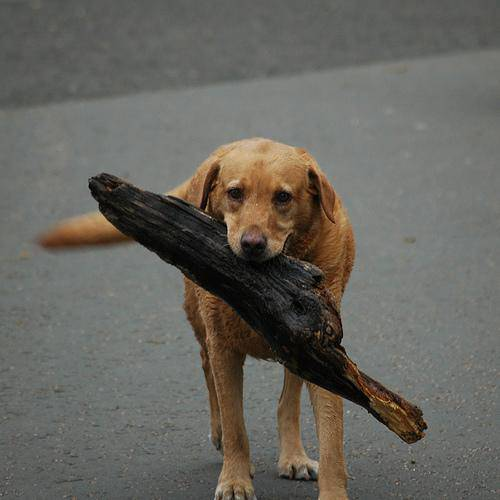

In [4]:
# View and image
from IPython.display import Image
Image(r"C:\Users\vbgup\CODE\PROJECTS\dog-breed-identification\train\0021f9ceb3235effd7fcde7f7538ed62.jpg")

### 6.1 Getting Images and Their Labels

Let's get a list of all of our image file path-names

In [5]:
# Create path names from image id's
filenames = ["C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/train/"  + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:5]

['C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [6]:
# Check whether number of filenames matches number of actual images files
import os
if len(os.listdir(r"C:\Users\vbgup\CODE\PROJECTS\dog-breed-identification\train")) == len(filenames):
  print("Length of filenames match actual amount of files")
else:
  print("Error")

Length of filenames match actual amount of files


tibetan_mastiff


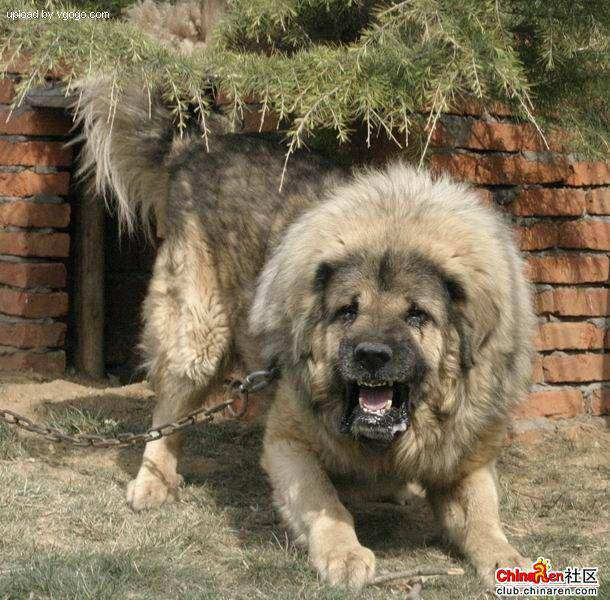

In [7]:
# One more check using index number
print(labels_csv["breed"][9000])
Image(filenames[9000])

### 6.2 Prepare the Labels
Since we have our training image filepaths in a list, we can prepare our labels -> turn them into numbers

In [8]:
labels = labels_csv["breed"]
labels = np.array(labels)
print(labels)
print(np.unique(labels)[:10])

unique_breeds = np.unique(labels)
print('--')
print("Total Number of Different Breeds:"   + str(len(unique_breeds)))

['boston_bull' 'dingo' 'pekinese' ... 'airedale' 'miniature_pinscher'
 'chesapeake_bay_retriever']
['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle']
--
Total Number of Different Breeds:120


In [9]:
# Turn all label into an array of booleans
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### 6.3 Creating a Valadation Set
Since Valadation set is not provided

In [10]:
# Setup X and y variables

X = filenames
y = boolean_labels

Experiments are going to be made on ~1000 images

In [11]:
NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max: 10000, step:1000 }

In [12]:
# Split the data into train and validation sets
from sklearn.model_selection import train_test_split

# Split based on total size
X_train, X_val, y_train, y_val = train_test_split(X[: 1000],
                                                  y[:1000],
                                                  test_size = 0.2,
                                                  random_state = 44)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

### 6.4 Preprocessing Images, Turning them into Tensors

Creating a function that;
1. Takes an image filepath as input
2. Uses tf to read the filepath and save it to the varaible `image`
3. Turns `img` into tensors
4. Resizes `image` 224,224
5. Returns modified `image`

In [13]:
# Define image size
IMG_SIZE = 224

# Function to preprocess the image
def process_image(image_path):
  '''
  takes an image file path and turns the image into a tensor
  '''
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the img into numerical Tensors with 3 color channels
  image = tf.image.decode_jpeg(image, channels = 3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image
  image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])

  return image

### 6.5 Turing the data into batches
Lets do 32 images at a time => 32 is the batch size

In [14]:
#Create a simple function to return a tuple(image, label)
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [15]:
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Turn all the data `X` & `y` into batches

In [16]:
# Define the batch sizr, 32 is a good start
BATCH_SIZE = 32

# Function to turn data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  '''
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it is traning data but not if validation data.
  Also accepts test data as input(no labels).
  '''

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating Test Data Batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  #If the data is a valid dataset, we do not shuffle it
  elif valid_data:
    print("Creating validation data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                             tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches")
    # Turn filespaths and lables into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size = len(X))
    
    #Create (image, label) tuples (this also turns the image path into preprocessed images)
    data = data.map(get_image_label)

    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [17]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches
Creating validation data batches


In [18]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### 6.6 Visualizing the data batches

In [19]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

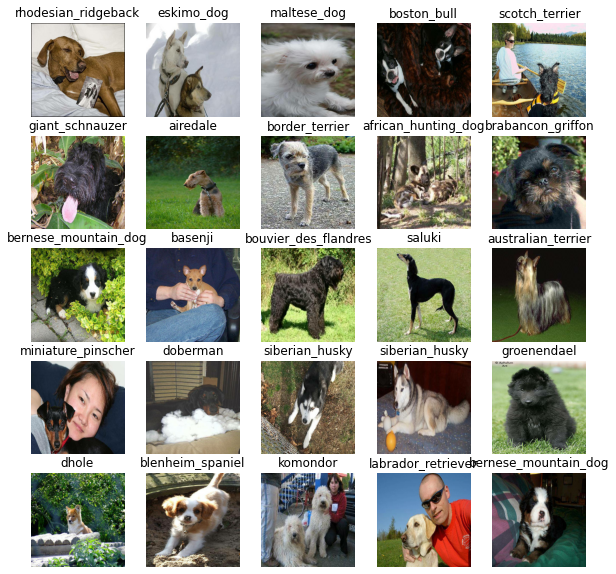

In [20]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

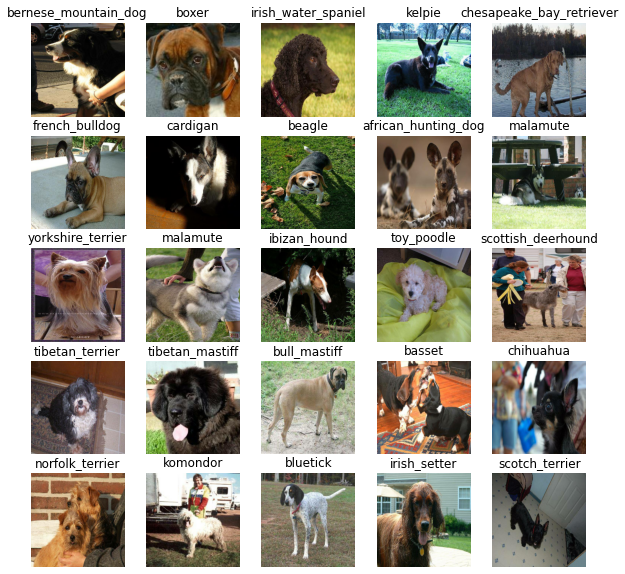

In [21]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## 7. Building a Model

Define:
* The input shape
* The output shape
* The URL of the model we want to use from tensorflow hub
> https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [22]:
# Setup imput shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Create a function which:
* Takes the input shape, output shape and model we've chosen as parameters
* Defines the layers in a Keras model in sequential fashion
* Complies the model
* Builds the model
* Returns the model

In [23]:
# Keras model function

def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Buliding Model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 - Input Layer
                               tf.keras.layers.Dense(units = OUTPUT_SHAPE, 
                                                     activation="softmax") # Layer 2 - Output layer
  ])


  # Compile the Model
  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
  
  # Build the model
  model.build(INPUT_SHAPE)
  return model

In [24]:
model = create_model()
model.summary()

Buliding Model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Create Callbacks

### Tensorboard Callback

In [25]:
# Load TensorBoard

%load_ext tensorboard
import datetime

# Create a function to build a tensorboard callback

def create_tensorboard_callbacks():

  logdir = os.path.join(r"C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

In [26]:
# Create early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience = 3)

## Training a Model

In [27]:
NUM_EPOCHS = 20

In [28]:
# Check GPU
print("GPU available" if tf.config.list_physical_devices("GPU") else "GPU Not available")

GPU Not available


In [29]:
# Function that creates a model

def train_model():

  model = create_model()

  # Tensorboard Session

  tensorboard = create_tensorboard_callbacks()

  # Fit the  model to the data

  model.fit(x = train_data,
            epochs = NUM_EPOCHS,
            validation_data = val_data,
            validation_freq = 1,
            callbacks = [tensorboard, early_stopping])
  
  # return fitted model
  return model



In [30]:
model = train_model()

Buliding Model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/20
25/25 [==============================] - 25s 882ms/step - loss: 4.5804 - accuracy: 0.0913 - val_loss: 3.1403 - val_accuracy: 0.3350
Epoch 2/20
25/25 [==============================] - 19s 781ms/step - loss: 1.6512 - accuracy: 0.6950 - val_loss: 1.8537 - val_accuracy: 0.5850
Epoch 3/20
25/25 [==============================] - 20s 794ms/step - loss: 0.5651 - accuracy: 0.9312 - val_loss: 1.3908 - val_accuracy: 0.6600
Epoch 4/20
25/25 [==============================] - 21s 839ms/step - loss: 0.2528 - accuracy: 0.9900 - val_loss: 1.2320 - val_accuracy: 0.7000
Epoch 5/20
25/25 [==============================] - 19s 771ms/step - loss: 0.1448 - accuracy: 0.9975 - val_loss: 1.1691 - val_accuracy: 0.7050
Epoch 6/20
25/25 [==============================] - 19s 780ms/step - loss: 0.1002 - accuracy: 0.9987 - val_loss: 1.1229 - val_accuracy: 0.7050
Epoch 7/20
25/25 [==============================]

**Question:** It looks like our model is overfitting becasue its performance is way better on the training set than the validation set.

### Checking the TensorBoard Logs

The TensorBoard magic function ('%tensorboard') will access the logs directory we created earlier and visualize its contents

In [31]:
%tensorboard --logdir 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/logs'

Reusing TensorBoard on port 6006 (pid 6880), started 2:19:38 ago. (Use '!kill 6880' to kill it.)

## Making and Evaluating Predictions using Trained Model

In [32]:
# Make predictions on validation data
predictions = model.predict(val_data, verbose = 1)
predictions

7/7 [==============================] - 4s 530ms/step


array([[1.1272350e-04, 8.7908320e-06, 2.9468340e-05, ..., 2.3024195e-05,
        3.4630290e-04, 3.3044850e-04],
       [1.0842379e-04, 5.9016042e-05, 9.8417959e-06, ..., 2.7264639e-05,
        1.0777154e-04, 9.0640251e-06],
       [9.4717187e-05, 5.7550595e-05, 4.2522573e-05, ..., 1.6551225e-05,
        1.5271162e-05, 2.5656207e-06],
       ...,
       [2.2045241e-04, 2.2207922e-05, 1.4351324e-04, ..., 2.5920532e-04,
        1.5188639e-04, 3.6657508e-05],
       [4.0115596e-05, 8.0908848e-07, 4.5593315e-06, ..., 7.3229364e-07,
        1.0552665e-06, 4.8590501e-04],
       [8.5785192e-05, 2.2850352e-05, 3.0459745e-05, ..., 2.1850379e-05,
        3.2365406e-05, 1.1932281e-03]], dtype=float32)

In [33]:
predictions.shape

(200, 120)

### Turn Prediction Probabilities into their Respective Labels

In [34]:
def get_pred_label(prediction_probas):
    
    return unique_breeds[np.argmax(prediction_probas)]

pred_label = get_pred_label(predictions[81])
pred_label

'entlebucher'

### Unbatch the val_data

In [35]:
def unbatchify(dataset):
    
    images_ = []
    labels_ = []
    
    for images, labels in dataset.unbatch().as_numpy_iterator():
        
        images_.append(images)
        labels_.append(unique_breeds[np.argmax(labels)])
        
    return images_, labels_


val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.38253656, 0.33005056, 0.39671725],
         [0.39007288, 0.33761382, 0.4041996 ],
         [0.3882505 , 0.33652484, 0.4009104 ],
         ...,
         [0.6425558 , 0.5580867 , 0.42135274],
         [0.64060557, 0.5465585 , 0.37419435],
         [0.6989901 , 0.5822009 , 0.400487  ]],
 
        [[0.23527732, 0.22053643, 0.26486418],
         [0.2631716 , 0.24654028, 0.29140618],
         [0.30117124, 0.274853  , 0.3158876 ],
         ...,
         [0.591317  , 0.5246922 , 0.388734  ],
         [0.60727173, 0.52386594, 0.3482765 ],
         [0.6351768 , 0.53510714, 0.34835058]],
 
        [[0.24187677, 0.2657213 , 0.31404063],
         [0.24192405, 0.26956236, 0.3097672 ],
         [0.24611345, 0.26242998, 0.30113798],
         ...,
         [0.47172153, 0.4274753 , 0.30893174],
         [0.6263348 , 0.568551  , 0.40058115],
         [0.591305  , 0.51581454, 0.33219227]],
 
        ...,
 
        [[0.7795137 , 0.6720558 , 0.494955  ],
         [0.73814404, 0.6306861 , 0.45358

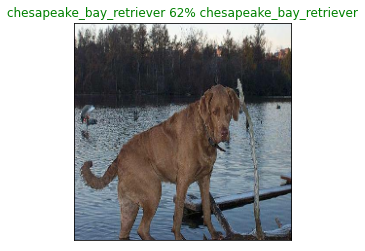

In [36]:
def plot_pred(prediction_probas, labels, images, n = 1):
    
    pred_prob, true_label, image = prediction_probas[n], labels[n], images[n]
    
    # Get pred label
    
    pred_label = get_pred_label(pred_prob)
    
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    
    # Change the color of the title depending on if the predicton is right or wrong
    
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"
    
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                     np.max(pred_prob)*100,
                                     true_label), color = color)
    

plot_pred(prediction_probas = predictions, labels = val_labels, images = val_images, n = 4)

### Lets get the top 10 predictions of a Particular Prediction

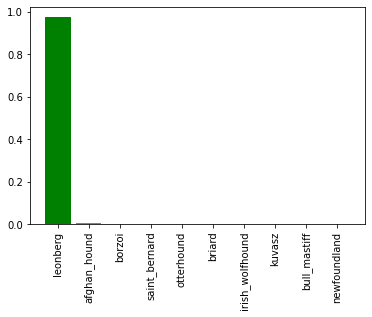

In [37]:
def plot_pred_conf(prediction_probs, labels, n = 1):
    
    pred_prob, true_label = prediction_probs[n], labels[n]
    
    pred_label = get_pred_label(pred_prob)
    
    # Find the top 10 prediction confidence indexes
    
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    
    # Find the top 10  prediction confidence values
    
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    
    # Find top 10 prediction labels
    
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]
    
    # Setup plot
    
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                      
                      top_10_pred_values,
                       color = "grey"
                        )
    plt.xticks(np.arange(len(top_10_pred_labels)),
              labels = top_10_pred_labels,
               rotation = "vertical"
              
              )
    
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

    else:
        pass

    
plot_pred_conf(predictions, val_labels, n = 50)

### Lets Look at a few Predictions and their Probabilities 

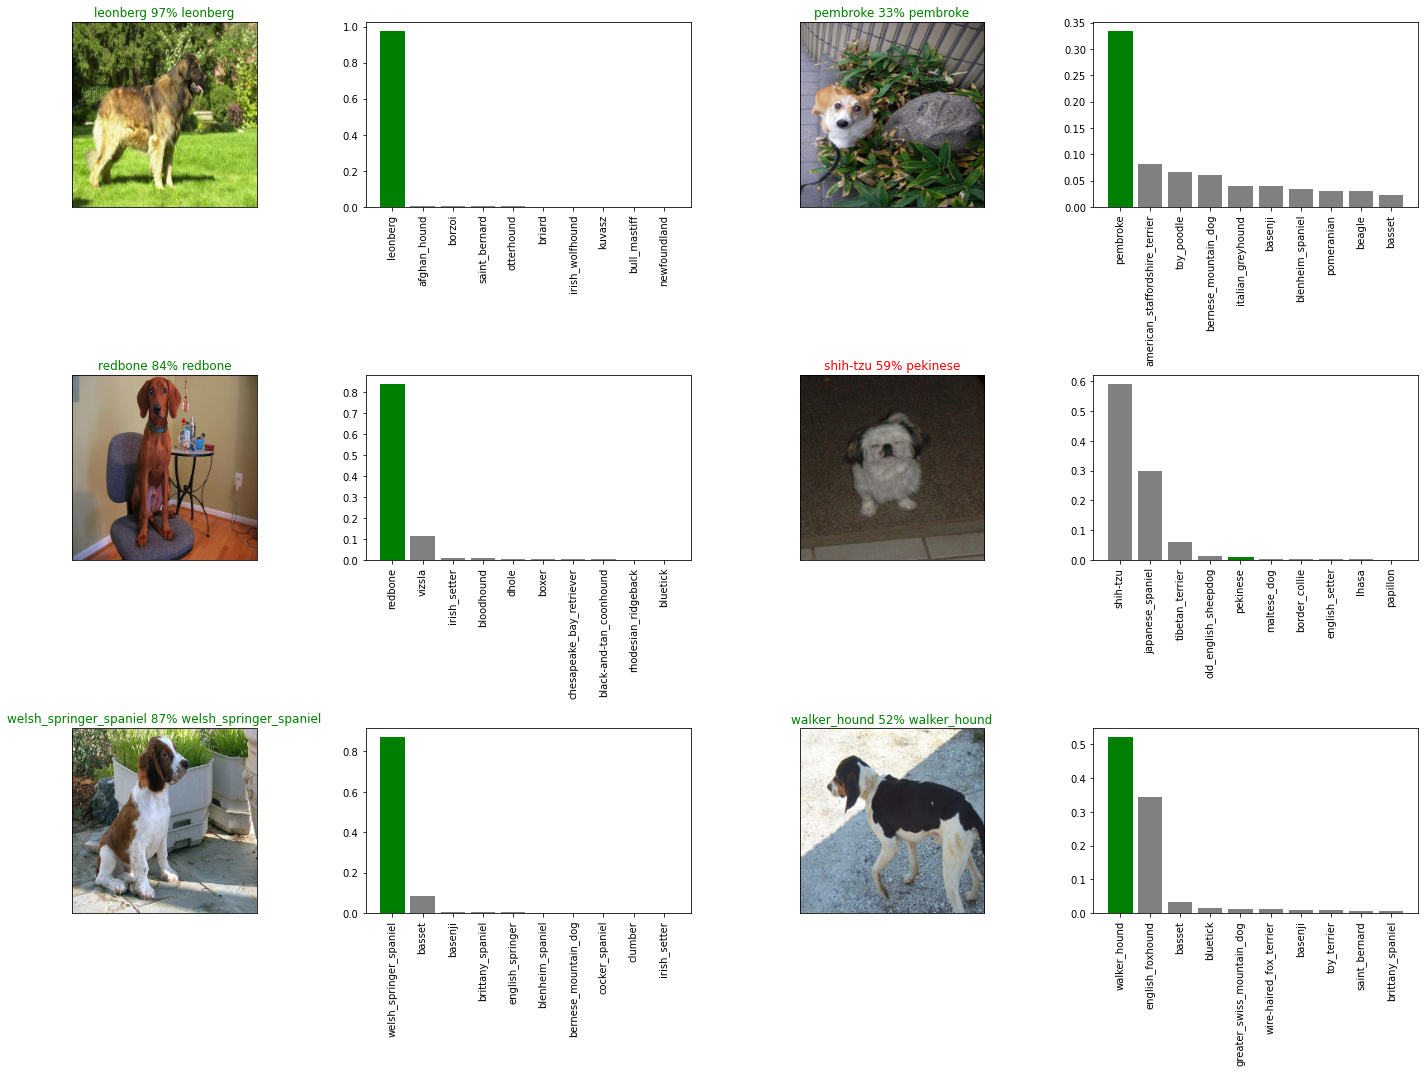

In [38]:
i_multiplier = 50
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
    
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    
    plot_pred(predictions, val_labels, val_images, n = i + i_multiplier)
    
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    
    plot_pred_conf(predictions, val_labels, n = i+i_multiplier)

plt.tight_layout(h_pad = 1.0)
plt.show()

## Save the trained Model

In [39]:
# Create a function to save a model

def save_model(model, suffix = None):
    
    modeldir = os.path.join("C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/models",
                           datetime.datetime.now().strftime("%Y%m%d"))
    
    model_path = modeldir + "-" + suffix + ".h5" # format for saving model
    
    print(f"Saving Model to: {model_path}...")
    model.save(model_path)
    return model_path

In [40]:
# Create a function to load the model

def load_model(model_path):
    
    print(f"Loading Saved Model: {model_path}")
    model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer": hub.KerasLayer})
    
    return model

In [41]:
# Save model on all images
save_model(model, suffix = "1000-Images-MobileNetV2-Adam")

Saving Model to: C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/models\20210517-1000-Images-MobileNetV2-Adam.h5...


'C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/models\\20210517-1000-Images-MobileNetV2-Adam.h5'

In [44]:
# Load a trained Model
loaded_all_img_model = load_model('C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/models\\20210517-1000-Images-MobileNetV2-Adam.h5')

Loading Saved Model: C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/models\20210517-1000-Images-MobileNetV2-Adam.h5


## Creating the Model on the Full Dataset🐶

In [45]:
len(X), len(y)

(10222, 10222)

In [46]:
# Create a data batch with the full data set

full_data = create_data_batches(X, y)

Creating training data batches


In [47]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [48]:
# Create a model for full data

full_data_model = create_model()

Buliding Model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [49]:
# Create full model call backs

full_model_tensorboard = create_tensorboard_callbacks()

full_model_earlystopping = tf.keras.callbacks.EarlyStopping(monitor = "accuracy", patience = 3)

In [50]:
# Fit the data to full data

full_data_model.fit(x = full_data, epochs = 100, callbacks=[full_model_tensorboard, 
                                                            full_model_earlystopping])

Epoch 1/100
320/320 [==============================] - 251s 772ms/step - loss: 1.3578 - accuracy: 0.6637
Epoch 2/100
320/320 [==============================] - 190s 592ms/step - loss: 0.4007 - accuracy: 0.8836
Epoch 3/100
320/320 [==============================] - 190s 594ms/step - loss: 0.2338 - accuracy: 0.9367
Epoch 4/100
320/320 [==============================] - 190s 592ms/step - loss: 0.1531 - accuracy: 0.9642
Epoch 5/100
320/320 [==============================] - 190s 592ms/step - loss: 0.1072 - accuracy: 0.9783
Epoch 6/100
320/320 [==============================] - 189s 592ms/step - loss: 0.0777 - accuracy: 0.9859
Epoch 7/100
320/320 [==============================] - 189s 592ms/step - loss: 0.0589 - accuracy: 0.9918
Epoch 8/100
320/320 [==============================] - 190s 592ms/step - loss: 0.0450 - accuracy: 0.9947
Epoch 9/100
320/320 [==============================] - 189s 592ms/step - loss: 0.0386 - accuracy: 0.9962
Epoch 10/100
320/320 [==============================] -

In [51]:
save_model(model, suffix = "All-Images-MobileNetV2-Adam")

Saving Model to: C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/models\20210517-All-Images-MobileNetV2-Adam.h5...


'C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/models\\20210517-All-Images-MobileNetV2-Adam.h5'

In [52]:
# Load the full model
load_full_model = load_model('C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/models\\20210517-All-Images-MobileNetV2-Adam.h5')

Loading Saved Model: C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/models\20210517-All-Images-MobileNetV2-Adam.h5


## Making Predictions on the test data

In [57]:
# Load image test path
test_path = 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/000621fb3cbb32d8935728e48679680e.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/00102ee9d8eb90812350685311fe5890.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/002f80396f1e3db687c5932d7978b196.jpg',
 'C:/Users/vbgup/CODE/PROJECTS/dog-breed-identification/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [58]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating Test Data Batches


In [59]:
# Make predictions on test data batch
test_predictions = load_full_model.predict(test_data, verbose = 1)

324/324 [==============================] - 246s 759ms/step


In [73]:
# Save Predictions to csv file 
np.savetxt('C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/preds_array.csv', test_predictions, delimiter = ',')

In [74]:
# Load the predictions back in
test_predictions = np.loadtxt('C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/preds_array.csv', delimiter = ",")

In [75]:
test_predictions[:10]

array([[9.08916772e-05, 1.62214681e-04, 1.08201505e-06, ...,
        1.99643473e-05, 2.17317756e-05, 1.38677278e-05],
       [8.25014140e-04, 7.85442826e-05, 2.73282843e-04, ...,
        5.25311101e-04, 1.81003226e-04, 5.41425215e-05],
       [3.70717839e-06, 6.59131911e-03, 2.67047109e-03, ...,
        2.58170476e-04, 4.15081799e-04, 2.19887661e-04],
       ...,
       [2.66158982e-04, 2.90775051e-06, 2.90279513e-05, ...,
        4.30476211e-05, 1.77430102e-05, 1.24261293e-04],
       [1.75138648e-05, 4.83887503e-03, 4.22553945e-04, ...,
        1.26944866e-03, 3.59567534e-03, 2.19540925e-05],
       [2.61231817e-05, 4.38936113e-05, 2.87824550e-05, ...,
        8.91705668e-07, 2.35088337e-05, 9.13273325e-05]])

## Preparing the Submission file for Kaggle
* https://www.kaggle.com/c/dog-breed-identification/data?select=sample_submission.csv

In [76]:
preds_df = pd.DataFrame(columns = ["id"] + list(unique_breeds))
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [77]:
# Append test id to predictions dataframe

test_id = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df['id'] = test_id

In [78]:
preds_df.head(3)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00102ee9d8eb90812350685311fe5890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012a730dfa437f5f3613fb75efcd4ce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Add the prediction probabilities to each dog breed column

preds_df[list(unique_breeds)] = test_predictions
preds_df.head(3)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000091,0.000162,0.000001,0.000002,0.000009,0.000018,0.000008,0.000015,0.000038,...,0.000018,0.000008,0.000013,0.000029,0.000014,0.000015,0.000001,0.00002,0.000022,0.000014
1,00102ee9d8eb90812350685311fe5890,0.000825,0.000079,0.000273,0.000346,0.000952,0.002045,0.000071,0.00106,0.000486,...,0.000583,0.000437,0.000302,0.000723,0.000037,0.000353,0.009649,0.000525,0.000181,0.000054
2,0012a730dfa437f5f3613fb75efcd4ce,0.000004,0.006591,0.00267,0.00194,0.000555,0.000207,0.000053,0.000142,0.000468,...,0.000242,0.000175,0.012766,0.003038,0.000122,0.014693,0.000286,0.000258,0.000415,0.00022


In [80]:
# Save to CSV
preds_df.to_csv('C:/Users/vbgup/CODE/PROJECTS/Dog-Breed-Classification/full_model_predictions_mobilenetv2.csv',
               index = False)

In [ ]:
## Make Predictions on Custom Images

custom_path = ""
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

In [ ]:
custom_data = create_data_batches(custom_image_paths, test_data = True)
custom_data

In [ ]:
# Make Predictions
custom_preds = load_full_model.predict(custom_data)
custom_preds

In [ ]:
#Image Prediction Label
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
custom_images  = []

for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

In [ ]:
plt.figure(figsize = (10,10))
for i, image in enumerate(custom_images):
    plt.sublots(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_preds_labels[i])
    plt.imshow(images)

___________